In [1]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2 as pg
import os
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
import scipy.stats as ss
register_matplotlib_converters()

In [509]:
host = os.getenv('RDS_HOST')
port = os.getenv('RDS_PORT')
database = os.getenv('RDS_DATABASE')
user = os.getenv('RDS_USER')
password = os.getenv('RDS_PASSWORD')
conn = pg.connect(host=host, port=port, database=database, user=user, password=password)
cur = conn.cursor()

In [3]:
stage_selector = 'deep'
group_selector = 'dow'


if group_selector == 'all':
    query = f"""
    SELECT "end"::date -1 "date", 
        {stage_selector}
    FROM sleep
    WHERE {stage_selector} IS NOT NULL
        AND user_id = '7BVHQT'
    ORDER BY "date" ASC;
    """

elif group_selector in ['dow', 'month', 'week']:
    query = f"""
    SELECT extract( {group_selector} FROM "end"::date -1 ) "{group_selector}",
        round( avg( {stage_selector} ), 2 ) {stage_selector}_avg,
        round( stddev( {stage_selector} ), 2 ) {stage_selector}_std
    FROM sleep
    WHERE {stage_selector} IS NOT NULL
        AND user_id = '7BVHQT'
    GROUP BY "{group_selector}"
    ORDER BY "{group_selector}" ASC;
    """

    
    
cur.execute(query)
data = cur.fetchall()
colname = [c[0] for c in cur.description]
data = pd.DataFrame(data, columns=colname)

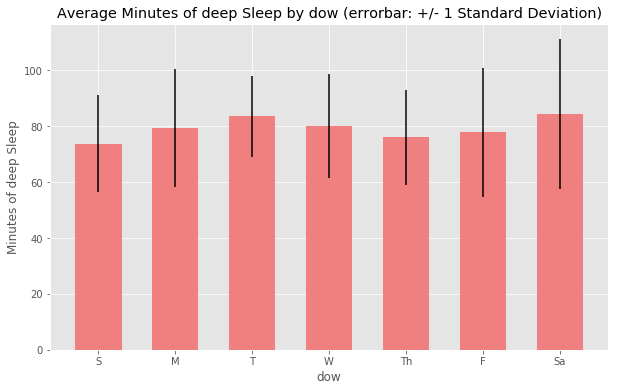

In [283]:
fig = plt.figure(figsize=(10,6))
if stage_selector == 'rem':
    bar_color = 'royalblue'
elif stage_selector == 'deep':
    bar_color = 'lightcoral'
    
plt.bar(
    data[f'{group_selector}'],
    data[f'{stage_selector}_avg'], 
    yerr=data[f'{stage_selector}_std'],
    width=0.6,
    color=bar_color,
    ecolor='black', 
    tick_label=['S', 'M', 'T', 'W', 'Th', 'F', 'Sa']    
)
plt.title(f'Average Minutes of {stage_selector} Sleep by {group_selector} (errorbar: +/- 1 Standard Deviation)')
plt.ylabel(f'Minutes of {stage_selector} Sleep')
plt.xlabel(f'{group_selector}')
fig.savefig('plot.png', format='png')

In [510]:

query = f"""
SELECT EXTRACT( DOW FROM "end"::date -1 )::int2 dow,
    date_trunc(
        'second', to_timestamp( 
            avg( 
                CASE WHEN EXTRACT( EPOCH FROM start::time ) < 60*60*12 
                    THEN EXTRACT( EPOCH FROM start::time ) + 60*60*24
                    ELSE EXTRACT( EPOCH FROM start::time )
                END
            )
        )::time
    ) avg_start,
    round(
        avg( 
            CASE WHEN EXTRACT( EPOCH FROM start::time ) < 60*60*12 
                THEN EXTRACT( EPOCH FROM start::time ) + 60*60*24
                ELSE EXTRACT( EPOCH FROM start::time )
            END
        )::dec /60, 2
    ) avg_start_epoch,
    
    round(
        stddev( 
            CASE WHEN EXTRACT( EPOCH FROM start::time ) < 60*60*12 
                THEN EXTRACT( EPOCH FROM start::time ) + 60*60*24
                ELSE EXTRACT( EPOCH FROM start::time )
            END
        )::dec / 60, 2 
    ) std_start
FROM sleep
WHERE deep IS NOT NULL
GROUP BY dow
ORDER BY dow ASC;
"""

cur.execute(query)
data = cur.fetchall()
colname = [c[0] for c in cur.description]
avg_start_by_dow = pd.DataFrame(data, columns=colname)
avg_start_by_dow

,dow,avg_start,avg_start_epoch,std_start
0,0,23:25:37,1405.63,87.78
1,1,23:01:38,1381.64,44.54
2,2,22:38:45,1358.75,57.03
3,3,22:56:17,1376.29,54.22
4,4,22:56:51,1376.86,71.71
5,5,00:06:12,1446.20,149.47
6,6,00:07:50,1447.84,108.40


# Sleep Start Time by DOW 

# monthly consistency

In [190]:
query = """
SELECT start::time start_time,
    CASE WHEN EXTRACT( EPOCH FROM start::time ) < 60*60*12 THEN EXTRACT( EPOCH FROM start::time ) + 60*60*24
        ELSE EXTRACT( EPOCH FROM start::time )
        END::real/60 start_epoch,
    EXTRACT( MONTH FROM "end"::date -1 )::int2 "month"
FROM sleep
WHERE NOW()-("end"::date-1) < INTERVAL '6 months' AND user_id LIKE '7B%' AND "end"-start > INTERVAL '3.5 hours'
ORDER BY start;
"""

cur.execute(query)
data = cur.fetchall()
colnames = [cn[0] for cn in cur.description]
df = pd.DataFrame(data, columns=colnames)

In [213]:
new_df = df.groupby('month').mean().reset_index().merge(df.groupby('month').std().reset_index(), on='month')
new_df.columns = ['month', 'avg', 'std']
new_df


,month,avg,std
0,4,1394.558824,68.155585
1,5,1396.403226,117.653759
2,6,1410.700000,99.313992
3,7,1406.724138,53.527127
4,8,1400.516667,111.832270
5,9,1366.071429,54.006003


# weekly inconsistency 

# Significance test 

In [275]:
n = 12
print(f"overall mean : {new_df.loc[:new_df.shape[0]-n,'std'].mean()}")
print(f"standard error : {new_df.loc[:new_df.shape[0]-n,'std'].std()}")
print(f"recent 3 months mean : {new_df.loc[new_df.shape[0]-n:,'std'].mean()}")
print(f"standard error : {new_df.loc[new_df.shape[0]-n:,'std'].std()/np.sqrt(n-1)}")
ss.ttest_1samp(new_df.loc[new_df.shape[0]-12:,'std'], 86.26).pvalue

0.19250714989457993